In [22]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras import backend as K
from mmnrm.utils import set_random_seed

from mmnrm.layers.interaction import SemanticInteractions, ExactInteractions
from mmnrm.layers.local_relevance import MultipleNgramConvs, MaskedSoftmax, SimpleMultipleNgramConvs
from mmnrm.layers.transformations import *
from mmnrm.layers.aggregation import *
from mmnrm.modelsv2 import savable_model, mish
from mmnrm.dataset import TestCollectionV2, TrainCollectionV2

from transformers import BertTokenizer, TFBertModel

import nltk

set_random_seed()


In [23]:
#tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract')

def transformer_model(func):
    def function_wrapper(**kwargs):
        # this setups the entired model tokenizer
        
        # create tokenizer
        if 'checkpoint_name' in kwargs:
            tokenizer = BertTokenizer.from_pretrained(kwargs['checkpoint_name'])
        else:
            raise ValueError('Missing checkpoint_name parameter in the config')
       
        model = func(**kwargs["model"])
        kwargs['func_name'] = func.__name__
        model.savable_config = kwargs
        model.tokenizer = tokenizer

        return model

    return function_wrapper


def train_test_generator_for_model(model):
    
    if "model" in model.savable_config:
        cfg = model.savable_config["model"]
    
    max_passages = cfg["max_passages"]
    max_input_size = cfg["max_input_size"]
    tokenizer = model.tokenizer
    
    def maybe_tokenize_pad(query,document):
        if "tokens" not in document:
            input_sentences = []
            sentences =  nltk.sent_tokenize(document["text"])[:max_passages]
            
            for sentence in sentences:
                input_sentences.append([query, sentence])
                
            document["sentences_mask"] = [True]*len(sentences)+[False]*(max_passages-len(sentences))
            
            #pad
            input_sentences.extend([""]*(max_passages-len(sentences)))

            encoded_sentences = tokenizer.batch_encode_plus(
                      input_sentences,
                      max_length=max_input_size,
                      truncation=True,
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=True,
                      padding="max_length",
                      return_attention_mask=True,
                      return_tensors='np',  # Return tf tensors
                )
            document["tokens"] = encoded_sentences
    
    def train_generator(data_generator):
        
        for query, pos_docs, neg_docs in data_generator:
            
            pos_input_ids = []
            pos_input_masks = []
            pos_input_segments = []
            pos_input_mask_sentences = []
                                                                        
            neg_input_ids = []
            neg_input_masks = []
            neg_input_segments = []
            neg_input_mask_sentences = []                                                            
                                                                    
            for i in range(len(query)):
                pos_doc = pos_docs[i]
                neg_doc = neg_docs[i]
                maybe_tokenize_pad(query[i], pos_doc)
                maybe_tokenize_pad(query[i], neg_doc)
                
                pos_input_ids.append(pos_doc["tokens"]["input_ids"])
                pos_input_masks.append(pos_doc["tokens"]["attention_mask"])
                pos_input_segments.append(pos_doc["tokens"]["token_type_ids"])
                pos_input_mask_sentences.append(pos_doc["sentences_mask"]) 
                                                                    
                neg_input_ids.append(neg_doc["tokens"]["input_ids"])
                neg_input_masks.append(neg_doc["tokens"]["attention_mask"])
                neg_input_segments.append(neg_doc["tokens"]["token_type_ids"])
                neg_input_mask_sentences.append(neg_doc["sentences_mask"]) 
                                                                        
            yield  [np.array(pos_input_ids, dtype="int32"), 
                    np.array(pos_input_masks, dtype="int32"),
                    np.array(pos_input_segments, dtype="int32"),
                    np.array(pos_input_mask_sentences, dtype="bool")],\
                   [np.array(neg_input_ids, dtype="int32"), 
                    np.array(neg_input_masks, dtype="int32"),
                    np.array(neg_input_segments, dtype="int32"),
                    np.array(neg_input_mask_sentences, dtype="bool")]
    
    def test_generator(data_generator):
        
        for ids, queries, docs in data_generator:
        
            input_query_ids = []

            input_ids = []
            input_masks = []
            input_segments = []

            input_mask_sentences = []
            docs_info = []

            for i in range(len(ids)):
                for doc in docs[i]:
                    maybe_tokenize_pad(queries[i], doc)
                    input_mask_sentences.append(doc["sentences_mask"])
                    input_ids.append(doc["tokens"]["input_ids"])
                    input_masks.append(doc["tokens"]["attention_mask"])
                    input_segments.append(doc["tokens"]["token_type_ids"])
                    docs_info.append(doc)
                    input_query_ids.append(ids[i])

            yield input_query_ids, [np.array(input_ids, dtype="int32"), 
                                    np.array(input_masks, dtype="int32"),
                                    np.array(input_segments, dtype="int32"),
                                    np.array(input_mask_sentences, dtype="bool")], docs_info
    
    return train_generator, test_generator
        
    

In [24]:
class AprioriLayerWmask(TrainableLayer):
    
    def __init__(self):
        super(AprioriLayerWmask, self).__init__()
        
        self.qtw_layer = QueryTermWeighting()
        
    def call(self, x):
        
        query_embeddings, query_mask, query_matches = x
        
        query_emb = query_embeddings * tf.expand_dims(query_mask, axis=-1)

        query_weights = self.qtw_layer(query_emb, mask=query_mask)

        return tf.reduce_sum(query_weights * query_matches, axis=-1, keepdims=True)

@transformer_model
def sibmtransfomer(max_passages = 20,
                   max_input_size = 128,
                   match_threshold = 0.8,
                   apriori_exact_match = False,
                   bert_train = False,
                   hidden_size = 768,
                   activation = "mish",
                   top_k_list = [3,5,10,15],): 
    
    if activation=="mish":
        activation = mish
    
    input_ids = tf.keras.layers.Input((max_passages, max_input_size,), dtype="int32") #
    input_masks = tf.keras.layers.Input((max_passages, max_input_size, ), dtype="int32") #
    input_segments = tf.keras.layers.Input((max_passages, max_input_size, ), dtype="int32") # 
    input_mask_passages = tf.keras.layers.Input((max_passages,), dtype="bool") # (None, P)
    
    bert_model = TFBertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', 
                                             output_attentions = False,
                                             output_hidden_states = False,
                                             return_dict=True,
                                             from_pt=True)
    bert_model.trainable = bert_train
    
    apriori_layer = AprioriLayerWmask()
    
    def skip_padding_data(input_ids, input_masks, input_segments, input_mask_passages):
        mask_passages = tf.reshape(input_mask_passages, shape=(-1,)) #None, 1
        mask_passages_indices = tf.cast(tf.where(mask_passages), tf.int32)
    
        input_ids = tf.gather_nd(tf.reshape(input_ids, shape=(-1, 128)),mask_passages_indices)
        input_masks = tf.gather_nd(tf.reshape(input_masks, shape=(-1, 128)),mask_passages_indices)
        input_segments = tf.gather_nd(tf.reshape(input_segments, shape=(-1, 128)),mask_passages_indices)
        
        return input_ids, input_masks, input_segments, mask_passages, mask_passages_indices
    
    def bert_contextualized_embeddings(input_ids, input_masks, input_segments):
        
        output = bert_model([input_ids, input_masks, input_segments])
        print(output)
        print(len(output))
        return output.pooler_output, output.last_hidden_state[:,1:,:]
    
    def embedding_matches_layer(embeddings, input_ids, input_masks, input_segments):
        
        #embeddings = x[0][:,1:,:] 
        #input_ids = x[1][:,1:]
        #input_masks = x[2][:,1:]
        #input_segments = x[3][:,1:]
        
        input_ids = input_ids[:,1:]
        input_masks = input_masks[:,1:]
        input_segments = input_segments[:,1:]
        
        # query mask, that will ignore the sep tokens
        #print(input_masks)
        #print(input_segments)
        mask_q = ((input_masks+input_segments)==1)
        mask_sep_tokens = input_ids == 3
        mask_q = tf.cast(tf.math.logical_xor(mask_sep_tokens,  (mask_q | mask_sep_tokens)), tf.float32)
        
        # sentence mask
        mask_s = tf.cast((input_segments==1), tf.float32)
        
        mask_interaction = tf.einsum("bq,bs->bqs", mask_q, mask_s)
        
        if apriori_exact_match:
            
            interaction_matrix = tf.cast(tf.einsum("bq,bs->bqs", input_ids, input_ids)==tf.expand_dims(tf.square(input_ids),axis=-1), tf.float32) * mask_interaction  
        else:
            ## using the embedding to perform the exact matching extraction
            embeddings = embeddings / tf.norm(embeddings, axis=-1, keepdims=True)

            interaction_matrix = tf.einsum("bqe,bse->bqs", embeddings, embeddings) * mask_interaction
            
        query_matches = tf.cast(tf.reduce_sum(tf.cast(interaction_matrix >= match_threshold, tf.int8), axis=-1)>0,tf.float32)
        
        return query_matches, mask_q
    
    l1_sentences_score = tf.keras.layers.Dense(1024, activation=activation)
    l2_sentences_score = tf.keras.layers.Dense(1, activation="sigmoid")
    
    def sentences_scores_layer(cls_embedding):
        
        x = l1_sentences_score(cls_embedding)
        x = l2_sentences_score(x)
        
        return x
    
    def document_features_layer(sentences_score, apriori_score, mask_passages, mask_passages_indices):

        x = apriori_score * sentences_score

        x = tf.scatter_nd(mask_passages_indices, tf.squeeze(x), tf.shape(mask_passages))
        
        x = tf.reshape(x, shape=(-1,max_passages,))
        
        top_k, indices = tf.math.top_k(x, k=top_k_list[-1], sorted=True)
        
        sentence_features = [tf.expand_dims(tf.math.reduce_max(x, axis=-1),axis=-1), 
                             tf.expand_dims(tf.math.reduce_sum(x, axis=-1),axis=-1), 
                             tf.expand_dims(tf.math.reduce_mean(x, axis=-1),axis=-1),
                            ]
        
        sentence_features += [ tf.expand_dims(tf.math.reduce_mean(top_k[:,:k], axis=-1),axis=-1) for k in top_k_list]
        
        return tf.concat(sentence_features, axis=-1)
        
    
    l1_score = tf.keras.layers.Dense(max_passages, activation=activation)
    l2_score = tf.keras.layers.Dense(1)
    
    def document_score(x):
        x = l1_score(x)
        x = l2_score(x)
        return x
    
    ## forward pass
    data_ids, data_masks, data_segments, mask_passages, mask_passages_indices = skip_padding_data(input_ids, input_masks, input_segments, input_mask_passages)
    
    cls_embedding, embeddings = bert_contextualized_embeddings(data_ids, data_masks, data_segments)
    
    query_matches, query_mask = embedding_matches_layer(embeddings, data_ids, data_masks, data_segments)
    
    sentence_scores = sentences_scores_layer(cls_embedding)
    
    apriori_scores = apriori_layer([embeddings, query_mask, query_matches])
    
    document_features = document_features_layer(sentence_scores, apriori_scores, mask_passages, mask_passages_indices)
    
    output_list = [document_score(document_features)]
    
    return tf.keras.models.Model(inputs=[input_ids, input_masks, input_segments, input_mask_passages], outputs=output_list)

In [25]:

cfg = {
    "checkpoint_name":'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
    "model":{
        "max_passages" : 20,
        "max_input_size" : 128,
        "match_threshold" : 0.9,
    }
}

rank_model = sibmtransfomer(**cfg)

rank_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint

TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor 'tf_bert_model_2/Identity:0' shape=(None, 128, 768) dtype=float32>, pooler_output=<tf.Tensor 'tf_bert_model_2/Identity_1:0' shape=(None, 768) dtype=float32>, hidden_states=None, attentions=None)
2
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape_5 (TensorFl [(None,)]            0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Where_1 (TensorFlow [(None, 1)]          0           tf_op_layer_Reshape_5[0][0]      
___________________________________

In [5]:
train_gen, test_gen = train_test_generator_for_model(rank_model)

train_collection = TrainCollectionV2\
                                .load("training_batch_01_250")\
                                .batch_size(32)\
                                .set_transform_inputs_fn(train_gen)

inference_data = TestCollectionV2.load("validation_data_batch_01_250")\
                           .batch_size(32)\
                           .set_transform_inputs_fn(test_gen)

In [6]:
#for pos, neg in train_collection.generator():
    
pos, neg = next(train_collection.generator())

In [ ]:
rank_model(next(inference_data.generator()))

In [36]:
train_collection = TrainCollectionV2\
                                .load("training_batch_01_250")\
                                .batch_size(32)\

docs_len = []
sentences_len = []
n_sentences = []

gen = train_collection.generator()
for j in range(850*5):
    
    if j% 1000 == 0:
        print(j)
            
    query, pos_docs, neg = next(gen)

    for batch_index in range(len(pos_docs)):

        docs_len.append(len(pos_docs[batch_index]["text"]))
        split = nltk.sent_tokenize(pos_docs[batch_index]["text"])
        n_sentences.append(len(split))
        sentences_len.extend([ len(x) for x in split])


0
1000
2000
3000
4000


In [32]:

import matplotlib.pyplot as plt
%matplotlib inline  

(array([4.9900e+02, 1.6950e+03, 4.0610e+03, 8.1840e+03, 1.2679e+04,
        1.9130e+04, 2.1487e+04, 2.0994e+04, 1.9379e+04, 1.3286e+04,
        6.0670e+03, 3.0390e+03, 2.1940e+03, 1.2570e+03, 6.7500e+02,
        2.3800e+02, 1.6900e+02, 2.7300e+02, 1.9500e+02, 7.9000e+01,
        5.7000e+01, 1.2200e+02, 5.7000e+01, 4.1000e+01, 3.5000e+01,
        1.4000e+01, 7.0000e+00, 2.0000e+00, 1.7000e+01, 2.2000e+01,
        2.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        1.3000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00]),
 array([ 140.  ,  334.72,  529.44,  724.16,  918.88, 1113.6 , 1308.32,
        1503.04, 1697.76, 1892.48, 2087.2 , 2281.92, 2476.64, 2671.36,
        2866.08, 3060.8 , 3255.52, 3450.24, 3644.96, 3839.68, 4034.4 ,
        4229.12, 4423.84, 4618.56, 4813.28, 5008.  , 5202.72, 5397.44,
        5592.16, 5786.88, 5981.6 ,

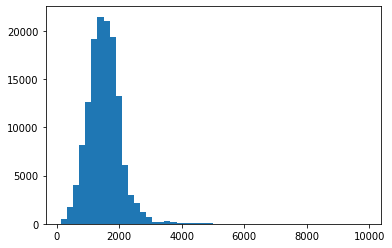

In [40]:
plt.hist(docs_len, bins=50)

(array([3.6400e+02, 9.6300e+02, 2.6120e+03, 4.8420e+03, 2.1825e+04,
        1.6642e+04, 1.6725e+04, 1.7275e+04, 1.5085e+04, 2.0728e+04,
        5.5980e+03, 4.3090e+03, 2.9250e+03, 3.1340e+03, 8.5900e+02,
        6.8000e+02, 3.3900e+02, 2.8700e+02, 2.7500e+02, 6.7000e+01,
        1.1400e+02, 1.1800e+02, 4.5000e+01, 1.7000e+01, 1.6000e+01,
        2.2000e+01, 2.3000e+01, 3.7000e+01, 8.0000e+00, 8.0000e+00,
        8.0000e+00, 8.0000e+00, 2.0000e+00, 1.7000e+01, 1.3000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00]),
 array([ 1.  ,  2.22,  3.44,  4.66,  5.88,  7.1 ,  8.32,  9.54, 10.76,
        11.98, 13.2 , 14.42, 15.64, 16.86, 18.08, 19.3 , 20.52, 21.74,
        22.96, 24.18, 25.4 , 26.62, 27.84, 29.06, 30.28, 31.5 , 32.72,
        33.94, 35.16, 36.38, 37.6 , 38.82, 40.04, 41.26, 42.48, 43.7 ,
        44.92, 46.14, 47.36, 48.58

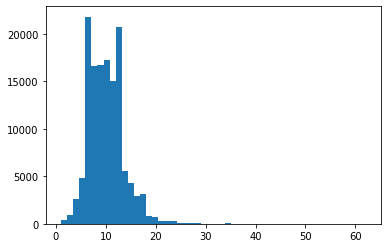

In [41]:
plt.hist(n_sentences, bins=50)

(array([5.29560e+04, 3.36493e+05, 4.45121e+05, 3.06245e+05, 1.41374e+05,
        5.69360e+04, 2.04260e+04, 7.09000e+03, 3.08100e+03, 1.21700e+03,
        6.50000e+02, 3.60000e+02, 1.30000e+02, 1.41000e+02, 6.60000e+01,
        5.20000e+01, 3.30000e+01, 2.20000e+01, 1.80000e+01, 2.30000e+01,
        1.50000e+01, 0.00000e+00, 0.00000e+00, 1.30000e+01, 2.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.00000e+00]),
 array([1.00000e+00, 5.35200e+01, 1.06040e+02, 1.58560e+02, 2.11080e+02,
        2.63600e+02, 3.16120e+02, 3.68640e+02, 4.21160e+02, 4.73680e+02,
        5.26200e+02, 5.78720e+02, 6.31240e+02, 6.83760e+02, 7.36280e+02,
        7.88800e+02, 8.41320e+02, 8.93840e+02, 9.

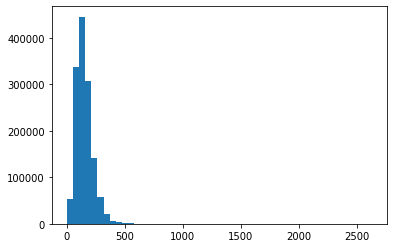

In [42]:
plt.hist(sentences_len, bins=50)

In [21]:
min(docs_len)

140

In [10]:
@tf.function
def untraced_static_model(kwargs):
    return rank_model(kwargs)

traced_model = untraced_static_model.get_concrete_function((next(train_collection.generator())[0]))

traced_model(pos) 

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.2021012 ],
       [0.16349386],
       [0.15401535],
       [0.08774568],
       [0.13155523],
       [0.18557489],
       [0.12081145],
       [0.28720528],
       [0.13876571],
       [0.21661234],
       [0.22450313],
       [0.2667594 ],
       [0.42713922],
       [0.17484169],
       [0.3498851 ],
       [0.18980098],
       [0.20608734],
       [0.19867793],
       [0.12750882],
       [0.05447982],
       [0.23414981],
       [0.13473289],
       [0.18844184],
       [0.09229364],
       [0.278794  ],
       [0.2618987 ],
       [0.13536623],
       [0.28666207],
       [0.21383315],
       [0.1153321 ],
       [0.28572255],
       [0.1950675 ]], dtype=float32)>

In [12]:
## run to the data training

count = 0
for pos, neg in train_collection.generator():
    count += 1
    if count%20:
        print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
281
282
283
284
285
286
287
288
289
290


KeyboardInterrupt: 

## Some tests

In [41]:
## inputs to test
max_passages = 20

def input_generator(data_generator):
    
    
    for ids, queries, docs in data_generator:
        
        input_query_ids = []

        input_ids = []
        input_masks = []
        input_segments = []

        input_text = []
        input_mask_sentences = []
        docs_info = []
        
        for i in range(len(ids)):
            for doc in docs[i]:
                input_sentences = []
                sentences =  nltk.sent_tokenize(doc["text"])[:20]
                for sentence in sentences:
                    input_sentences.append([queries[i],sentence])
                input_mask_sentences.append([True]*len(sentences)+[False]*(max_passages-len(sentences)))
                #pad
                input_sentences.extend([""]*(20-len(sentences)))
                
                encoded_sentences = tokenizer.batch_encode_plus(
                          input_sentences,
                          max_length=128,
                          truncation=True,
                          add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                          return_token_type_ids=True,
                          padding="max_length",
                          return_attention_mask=True,
                          return_tensors='np',  # Return tf tensors
                    )
                input_ids.append(encoded_sentences["input_ids"])
                input_masks.append(encoded_sentences["attention_mask"])
                input_segments.append(encoded_sentences["token_type_ids"])
                docs_info.append(doc)
                input_query_ids.append(ids[i])
        
        yield input_query_ids, [np.array(input_ids, dtype="int32"), 
                                np.array(input_masks, dtype="int32"),
                                np.array(input_segments, dtype="int32"),
                                np.array(input_mask_sentences, dtype="bool")], docs_info

inference_data = TestCollectionV2.load("validation_data_batch_01_250")\
                           .batch_size(10)\
                           .set_transform_inputs_fn(input_generator)



In [42]:
data = next(inference_data.generator())

In [67]:
rank_model(data[1])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.24755947],
       [-0.11821245],
       [-0.52642405],
       [-0.40074426],
       [-0.23962358],
       [-0.2918184 ],
       [-0.24602206],
       [-0.21049237],
       [-0.24049833],
       [-0.28115588]], dtype=float32)>

In [219]:
a = next(gen)



Y0,Y1,Y2 = a[1][0],a[1][1],a[1][2]

print(Y0)

mask_passages = tf.reshape(a[2], shape=(-1,)) #None, 1
mask_passages_indices = tf.cast(tf.where(mask_passages), tf.int32)

Y0 = tf.gather_nd(tf.reshape(Y0, shape=(-1, 128)),mask_passages_indices)
Y1 = tf.gather_nd(tf.reshape(Y1, shape=(-1, 128)),mask_passages_indices)
Y2 = tf.gather_nd(tf.reshape(Y2, shape=(-1, 128)),mask_passages_indices)

print(Y0.shape,Y1.shape,Y2.shape)

output = model([Y0,Y1,Y2])

[[[   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  ...
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]]

 [[   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  ...
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]]

 [[   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  ...
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]]

 ...

 [[   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  [   2 1810 7760 ...    0    0    0]
  ...
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]
  [   2    3    0 ...    0    0    0]]

 [[   2 1810 7760 ...    0    0    0]
  [   2 1810

In [207]:
y_old

array([[[[   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         ...,
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0]],

        [[   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         ...,
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0]],

        [[   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         [   2, 1810, 7760, ...,    0,    0,    0],
         ...,
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0],
         [   2,    3,    0, ...,    0,    0,    0]],

        ...,

  

In [193]:
a = next(gen)

Y0,Y1,Y2 = a[1][0],a[1][1],a[1][2]

print(Y0.shape)

Y0 = tf.reshape(Y0, shape=(-1, 128))

Y0.shape

print(Y0[0])

(10, 20, 128)
tf.Tensor(
[    2  1810  7760 10998  5345  5161  1772  5926    34     3  5161  5879
  1690  4442  1685  1680  7760 16907  1682  1808  1715  5069  2310    17
     3     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int64)


In [281]:
# tirar as query embeddings
mask_q = ((Y1+Y2)==1)[:,1:]
mask_sep_tokens = Y0[:,1:][0] == 3
mask_q = tf.cast(tf.math.logical_xor(mask_sep_tokens,  (mask_q | mask_sep_tokens)), tf.float32)
print()
print(mask_q.shape)


# tirar as sentences
mask_s = tf.cast((Y2==1)[:,1:], tf.float32)
print(mask_s.shape)


# fazer matrix de interação
mask_interaction = tf.einsum("bq,bs->bqs",tf.squeeze(mask_q), tf.squeeze(mask_s))
print(mask_interaction.shape)





(113, 127)
(113, 127)
(113, 127, 127)


In [323]:
hidden = output.last_hidden_state[:,1:,:] 
hidden = hidden / tf.norm(hidden, axis=-1, keepdims=True)

interaction_matrix = tf.einsum("bqe,bse->bqs", hidden, hidden) * mask_interaction

q_matches = tf.cast(tf.reduce_sum(tf.cast(interaction_matrix >= 0.95, tf.int8), axis=-1)>0,tf.float32)
q_matches.shape

TensorShape([113, 127])

In [317]:

#query_matches = tf.cast(tf.reduce_sum(tf.cast(tf.squeeze(x, axis=-1)>=match_threshold, tf.int8), axis=-1)>0,tf.int8)

TensorShape([113, 127])

In [298]:
interaction_matrix = tf.cast(tf.einsum("bq,bs->bqs", input_ids, input_ids)==tf.expand_dims(tf.square(Y0[:,1:]),axis=-1), tf.float32) * mask_interaction  

TensorShape([113, 127])

In [308]:


qtw_layer = QueryTermWeighting()     

#q_emb = output.last_hidden_state[:,1:,:] * tf.expand_dims(mask_q, axis=-1)

q_weights = qtw_layer(output.last_hidden_state[:,1:,:], mask=mask_q)

tf.reduce_sum(q_weights * q_matches, axis=-1)

<tf.Tensor: shape=(113,), dtype=float32, numpy=
array([0.17012967, 0.        , 0.148293  , 0.        , 0.        ,
       0.        , 0.03487577, 0.        , 0.07097486, 0.06124848,
       0.4395971 , 0.45100248, 0.2145535 , 0.31272617, 0.        ,
       0.1266037 , 0.10325293, 0.        , 0.        , 0.06049447,
       0.07832406, 0.4352486 , 0.44407433, 0.34385943, 0.3726548 ,
       0.38931778, 0.35014176, 0.05771575, 0.04074939, 0.        ,
       0.50849384, 0.06118636, 0.        , 0.53054667, 0.36428207,
       0.        , 0.14523561, 0.47055268, 0.        , 0.02959868,
       0.04281685, 0.12004687, 0.21203166, 0.20622854, 0.06787077,
       0.5395304 , 0.        , 0.        , 0.        , 0.        ,
       0.39897323, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.14148958, 0.        , 0.22246706, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2642048 , 0.        ,
       0.     

In [303]:
output.last_hidden_state[:,1:,:]

<tf.Tensor: shape=(113, 127, 768), dtype=float32, numpy=
array([[[-9.97197628e-01,  8.22079003e-01,  1.37871742e-01, ...,
          1.05122340e+00,  9.97862041e-01, -1.11376762e+00],
        [ 7.29606569e-01,  2.77180552e-01,  5.56441307e-01, ...,
         -2.01994970e-01,  5.64241052e-01, -1.34539217e-01],
        [ 3.21850270e-01,  9.25644338e-02,  5.59158385e-01, ...,
          9.66627598e-01,  5.34669459e-01, -3.57550293e-01],
        ...,
        [-5.95068857e-02,  6.22919977e-01,  2.34810039e-01, ...,
          2.04758286e-01,  4.04620826e-01, -5.64388514e-01],
        [-5.01044393e-01,  2.29121402e-01, -5.80734491e-01, ...,
         -5.04128993e-01,  2.92268664e-01,  4.56588507e-01],
        [-5.52678108e-01,  2.48574167e-01, -4.88777459e-01, ...,
         -5.96769452e-01,  3.83230954e-01,  4.54718083e-01]],

       [[-1.22354209e+00,  8.41383994e-01, -6.24941811e-02, ...,
          1.12025619e+00,  9.84804511e-01, -1.08045471e+00],
        [ 3.67276490e-01,  5.53612113e-01,  3.

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2])

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([5, 5, 5, 0, 4, 4, 0, 0, 3, 0, 0, 0])>

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([5, 5, 5, 4, 4, 3])>

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [69]:
from mmnrm.dataset import TestCollectionV2, TrainCollectionV2

train_collection = TrainCollectionV2\
                                .load("training_batch_01_250")\
                                .batch_size(32)

In [70]:
q, pos_doc, neg_doc = next(train_collection.generator())

In [71]:
q

array(['How many genes in S. cerevisiae are the result of an ancient whole genome duplication?',
       'What is FINDbase?',
       'Are stress granules involved in the pathogenesis of Amyotrophic Lateral Sclerosis?',
       'Is the crystal structure of Pim-1 available?',
       'What is the mechanism of action of  trichostatin A (TSA) as an antitumoral agent?',
       'Which diseases are associated with Alu element insertion?',
       'List disorders that are caused by mutations in the mitochondrial MTND6 gene.',
       'What does isradipine do to L-type channels?',
       'Where, in the body, would the Cobb-Stainsby excision arthroplasty be performed?',
       'Which are the main causes of fetal echogenic bowel?',
       'For which indications has midostaurin received FDA and EMA approval?',
       'Is subdural empyema a complication of sinusitis?',
       'Which drug can be reversed with idarucizumab?',
       'List human diseases involving genomic imprinting.',
       'Which tool e

In [73]:
len(pos_doc)

32

In [6]:
validation_collection = TestCollectionV2.load("validation_data_batch_01_250")\
                                    .batch_size(32)\
                                    .set_transform_inputs_fn(test_gen)\
                                    .set_name("Validation TOP 250")

In [7]:
from collections import defaultdict

def get_q_results():
    q_results = defaultdict(list)
    count = 0
    for q_id, Y, docs_id in validation_collection.generator():

        count+=1
        if count%8 == 0:
            print(count)
        for i in range(len(q_id)):
            q_results[q_id[i]].append(docs_id[i]["id"])
    return q_results


In [8]:
validation_collection.batch_size(250)
original = get_q_results()

validation_collection.batch_size(32)
withbatch32 = get_q_results()

8
16
24
32
40
48
56
64
72
80
88
96
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776


In [35]:
#validation_collection.batch_size(32)


In [45]:
different_samples = 0
for k in original.keys():

    for i in range(min(len(withbatch32[k]), len(original[k]))):
        if original[k][i] != withbatch32[k][i]:
            different_samples += 1
        
    different_samples += max(len(withbatch32[k]), len(original[k])) - min(len(withbatch32[k]), len(original[k]))


In [46]:
different_samples

8

In [10]:
bert_model = TFBertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', 
                                             output_attentions = False,
                                             output_hidden_states = False,
                                             return_dict=True,
                                             from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint

In [14]:
bert_model.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [30]:
for _input in rank_model.inputs:
    _input.shape[0]
    print(tf.keras.layers.Input(_input.shape[1:], dtype="int32"))#

Tensor("input_17:0", shape=(None, 20, 128), dtype=int32)
Tensor("input_18:0", shape=(None, 20, 128), dtype=int32)
Tensor("input_19:0", shape=(None, 20, 128), dtype=int32)
Tensor("input_20:0", shape=(None, 20), dtype=int32)
